In [1]:
# Import our standard libraries.
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style
import tensorflow as tf
import pandas as pd

## Understanding the Embeddings Layer

In [2]:
# Input shape:  (batch_size, input_length)
# Output shape: (batch_size, input_length, output_dim)
embeddings = tf.keras.layers.Embedding(
    input_dim = 100,  # size of feature vocabulary
    output_dim = 2,   # embedding dimension
    input_length = 5  # number of inputs
    )

In [3]:
data = tf.constant([0, 1, 2, 3, 4], shape=(1, 5))
data[0].numpy()

array([0, 1, 2, 3, 4], dtype=int32)

In [4]:
# Get embeddings for the input ids [0, 1, 2, 3, 4]
data = tf.constant([0, 1, 2, 3, 4], shape=(1, 5))
embed_data = embeddings(data)
embed_data.numpy()

array([[[ 0.03155569, -0.02880342],
        [-0.0452475 , -0.04974592],
        [ 0.01206049, -0.02634952],
        [-0.02141825, -0.04246259],
        [-0.02787409, -0.01105261]]], dtype=float32)

In [5]:
# Average embeddings
embed_data_average = tf.keras.layers.GlobalAveragePooling1D()(embed_data)
embed_data_average.numpy()

array([[-0.01018473, -0.03168281]], dtype=float32)

## Embeddings for Text

Let's store our small set of movie reviews and their labels in numpy arrays

In [6]:
X_train = np.array([
                    'This movie was amazing',
                    'I have seen it 8 times !',
                    'I fell asleep',
                    'I would not recommend it',
                    'It was absolutely awful',
                    'I would watch it again !'
                  ])

Y_train = np.array([
                    1,
                    1,
                    0,
                    0,  
                    0, 
                    1
                  ])


In [7]:
display(X_train[0])

'This movie was amazing'

In [8]:
max_sequence_length = 6

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=None, # Maximum vocabulary size - None -> no cap
    standardize='lower_and_strip_punctuation', # Standarization to apply to text - None -> no standarization
    split="whitespace", # Values can be None (no splitting), "whitespace", or a Callable
    output_mode='int',  # Values can be "int", "multi_hot", "count" or "tf_idf"
    output_sequence_length=max_sequence_length, # Only valid in INT mode. If set, the output will have its time dimension padded or truncated to exactly output_sequence_length values
    )

vectorize_layer.adapt(X_train)

display("--Vocabulary--")
for i, token in enumerate(vectorize_layer.get_vocabulary()):
  display('%d: %s' %(i, token))

# 0: ('') - Padding Token
# 1: ('[UNK]') - OOV Token

'--Vocabulary--'

'0: '

'1: [UNK]'

'2: it'

'3: i'

'4: would'

'5: was'

'6: watch'

'7: times'

'8: this'

'9: seen'

'10: recommend'

'11: not'

'12: movie'

'13: have'

'14: fell'

'15: awful'

'16: asleep'

'17: amazing'

'18: again'

'19: absolutely'

'20: 8'

In [9]:
X_train_vectorized = vectorize_layer(X_train)

display(X_train_vectorized)

<tf.Tensor: shape=(6, 6), dtype=int64, numpy=
array([[ 8, 12,  5, 17,  0,  0],
       [ 3, 13,  9,  2, 20,  7],
       [ 3, 14, 16,  0,  0,  0],
       [ 3,  4, 11, 10,  2,  0],
       [ 2,  5, 19, 15,  0,  0],
       [ 3,  4,  6,  2, 18,  0]])>

In [10]:
vocab_size = len(vectorize_layer.get_vocabulary())

# Input shape:  (batch_size, input_length)
# Output shape: (batch_size, input_length, output_dim)
embedding_layer = tf.keras.layers.Embedding(
    input_dim = vocab_size,  # size of feature vocabulary
    output_dim = 2,   # embedding dimension
    input_length = max_sequence_length  # number of inputs
    )

first_review_embed_rep = embedding_layer(X_train_vectorized[0])
display(first_review_embed_rep)

<tf.Tensor: shape=(6, 2), dtype=float32, numpy=
array([[ 0.0125216 ,  0.02773574],
       [-0.01848136,  0.01387316],
       [ 0.02856031,  0.00809778],
       [ 0.02628567, -0.03921146],
       [-0.02038398, -0.0034708 ],
       [-0.02038398, -0.0034708 ]], dtype=float32)>

In [11]:
def build_model():
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(vectorize_layer)
  model.add(tf.keras.layers.Embedding(
      input_dim = vocab_size,  # size of feature vocabulary
      output_dim = 2,  # embedding dimension
      input_length = max_sequence_length  # number of inputs
      ))

  # Average over the sequence dimension, so each review is represented by 
  # 1 vector of size embedding_dimension
  model.add(tf.keras.layers.GlobalAveragePooling1D()) 

  # Alternatively, we could concatenate the embedding representations of 
  # all tokens in the movie review
  #model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(
      units=8,        
      activation='relu'))

  model.add(tf.keras.layers.Dense(
      units=1,        
      activation='sigmoid'))

  model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
  
  return model

In [12]:
model = build_model()

# Display the model layers.
display(model.layers)
display(model.summary())

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings = model.layers[1].get_weights()[0]
display("Embeddings layer - shape: ", embeddings.shape)
display("Embeddings layer - parameter matrix (before training): ", embeddings)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 6)                0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 6, 2)              42        
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 75
Trainable params: 75
Non-trainable para

None

'Embeddings layer - shape: '

(21, 2)

'Embeddings layer - parameter matrix (before training): '

array([[-0.02080249, -0.02934336],
       [ 0.00353907,  0.00612575],
       [-0.00833255,  0.03078279],
       [-0.00067749,  0.04981292],
       [ 0.01967352, -0.03746264],
       [ 0.02098167,  0.01624156],
       [ 0.00722566, -0.01352465],
       [-0.00794817,  0.0130057 ],
       [ 0.0413813 ,  0.01616472],
       [ 0.03334736, -0.0416042 ],
       [-0.02202406, -0.04844768],
       [ 0.02263736,  0.02655387],
       [ 0.01798667,  0.00327279],
       [ 0.02565141, -0.04525781],
       [-0.04496286,  0.02517435],
       [-0.03272872, -0.01880648],
       [-0.02086261, -0.03994876],
       [-0.03343292,  0.02696652],
       [ 0.00856798,  0.04820097],
       [ 0.04148327, -0.03583347],
       [-0.04024345,  0.01062784]], dtype=float32)

In [13]:
def plot_embeddings(model):
  embeddings = model.layers[1].get_weights()[0]
  plt.scatter(embeddings[:,0], embeddings[:,1])
  for i, token in enumerate(vectorize_layer.get_vocabulary()):
    plt.annotate(token, (embeddings[i]))
  plt.show()

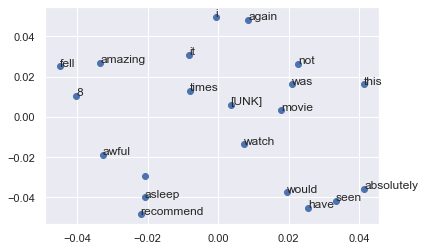

In [14]:
plot_embeddings(model)

In [15]:
display(X_train)
display(model.predict(X_train))

array(['This movie was amazing', 'I have seen it 8 times !',
       'I fell asleep', 'I would not recommend it',
       'It was absolutely awful', 'I would watch it again !'],
      dtype='<U24')

array([[0.49993494],
       [0.4996607 ],
       [0.5028277 ],
       [0.5002368 ],
       [0.5008004 ],
       [0.4990555 ]], dtype=float32)

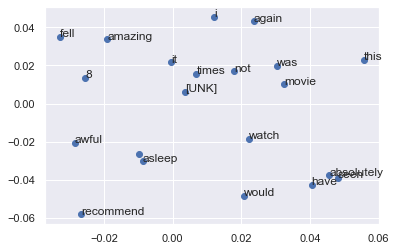

In [16]:
history = model.fit(
  x = X_train,  # our sparse padded training data
  y = Y_train,  # corresponding binary labels
  epochs=15,    # number of passes through the training data
  verbose=0     # display some progress output during training
  )

plot_embeddings(model)

In [17]:
display(X_train)
display(model.predict(X_train))

array(['This movie was amazing', 'I have seen it 8 times !',
       'I fell asleep', 'I would not recommend it',
       'It was absolutely awful', 'I would watch it again !'],
      dtype='<U24')

array([[0.50098765],
       [0.5007835 ],
       [0.49886107],
       [0.49937138],
       [0.49927565],
       [0.50067824]], dtype=float32)